In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st 

# Материалы:

Презентация: https://disk.yandex.ru/i/VGzvL-rQeTT-_A

Дашборд: https://public.tableau.com/app/profile/st9678/viz/Book1_16443602779340/Dashboard1?publish=yes

# Оценка эффективности торговых точек

Используя данные о покупках, выделить эффективные торговые точки, и по их прообразу составить модель развития других магазинов.

## Предобработка данных

Произведем обязательное преобразование данных, очистим их от мусора и заполним пропуски, для более корректного исследования.

### Получение данных из файла и первое знакомство с ними

Имеется два файла с расширением .csv, с помощью методов библиотеки Pandas, превратим хранимые в файлах данные в датасеты.

In [3]:
df = pd.read_csv('retail_dataset.csv')
display(df.head())
print(f'Количество строк в датасете: {df.shape[0]}')

,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


Количество строк в датасете: 105335


In [4]:
df_1 = pd.read_csv('product_codes.csv')
display(df_1.head())
print(f'Количество строк в датасете: {df_1.shape[0]}')

,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


Количество строк в датасете: 9969


### Изменение названий колонок 

Столбцы имеют не очень удобные названия, так что начнем с их переименования.

In [5]:
df.columns = ['purchase_id', 'product_id', 'quantity', 'purchase_date', 'customer_id', 'shop_id', 'loyalty']
df.head()

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0


In [6]:
df_1.columns = ['product_id', 'price']
df_1.head()

,product_id,price
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39


### Поиск и обработка пропущенных значений

Проверим наличие пропусков в данных и осуществим их обработку, если они присутствуют.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
purchase_id      105335 non-null object
product_id       105335 non-null object
quantity         105335 non-null int64
purchase_date    105335 non-null object
customer_id      69125 non-null float64
shop_id          105335 non-null object
loyalty          105335 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


В столбце с идентификаторами пользователей имеется порядка 36 тысяч пропусков. Есть предположение, что часть пользовательских ID получится восстановить, взяв их из чека. Например, допустим в чеке есть наименование для которого ID указан, тогда этот идентификатор можно будет использовать и для других позиций чека.

In [8]:
df['counter'] = df.groupby('purchase_id')['customer_id'].transform('sum')
df[df['counter'] != 0]

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty,counter
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0,202697.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0,380613.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0,665460.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0,870314.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0,1504815.0
...,...,...,...,...,...,...,...,...
105328,537886,22158,7,2016-12-09 09:49:00,21339.0,Shop 0,0.0,213390.0
105331,540247,21742,0,2017-01-05 15:56:00,21143.0,Shop 0,0.0,3319451.0
105332,538068,85048,1,2016-12-09 14:05:00,23657.0,Shop 0,1.0,283884.0
105333,538207,22818,11,2016-12-10 11:33:00,18427.0,Shop 0,0.0,1013485.0


In [9]:
df =  df.drop('counter', axis=1)

К сожалению не удалось восстановить ниодного идентификатора, NaN значения столбца 'customer_id' были для всего чека.
На данном этапе просто заменим пропуски на значение - 'Unknown'.

In [10]:
df['customer_id'] = df['customer_id'].fillna('Unknown')

### Поиск и обработка дубликатов

Проверим имеются ли в данных дубликаты и избавися от них.

In [11]:
print(f'Количество дубликатов в df: {df.duplicated().sum()}')

Количество дубликатов в df: 1033


Обнаружено 1033 дубликата, вот только дубликаты у которых количество товара равно 1, можно посчитать просто как товар который был внесен в чек более одного раза, вместо увеличения количества товара в изначальной позиции. Поэтому эти данные нужно оставить, а вот дубликаты с количеством товара более одного, больше похожы на "мусор", от них нужно избавиться.

In [12]:
df = df[(~df.duplicated()) | ((df.duplicated()) & (df['quantity'] == 1))]
df = df.reset_index(drop=True)
display(df.head())
print(f'Количество строк в датасете: {df.shape[0]}')

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1.0


Количество строк в датасете: 104423


In [13]:
print(f'Количество дубликатов в df_1: {df_1.duplicated().sum()}')

Количество дубликатов в df_1: 0


In [14]:
print(f'Количество уникальных product_id: {df_1["product_id"].nunique()}')

Количество уникальных product_id: 3159


На некоторые товары имеется несколько цен, что совершенно неприемлимо. Так же имеются товары с нулевой ценой, поскольку как-либо восстановить эти данные не имеется возможности, их следует удалить. Вероятнее всего эти ошибки вызванны системными или техническими сбоями.

In [15]:
df_1 = df_1[df_1['price'] != 0]

Предположительно, различние цены на одни и те же товары возникли из-за того, что в разных магазинах они могут отличаться, или это стоимости товара с учетом скидки и без нее. Избавимся от большого количества значений цены, просто взяв среднее значение от всех стоимостей товара.

In [16]:
df_1 = df_1.groupby('product_id').mean().reset_index()
df_1['price'] = df_1['price'].round(2)
df_1

,product_id,price
0,10002,1.38
1,10080,0.85
2,10120,0.21
3,10123C,0.65
4,10124A,0.42
...,...,...
3097,gift_0001_20,16.84
3098,gift_0001_30,25.26
3099,gift_0001_40,34.04
3100,gift_0001_50,42.55


Было утеряно 52 наименования товара, так как не было возможности восстановить нулевые значения цены товара.

### Приведение данных к нужным типам

Измененим типы данных, для простоты и дальнейшего удобства в работе с ними.

In [17]:
df.dtypes

purchase_id       object
product_id        object
quantity           int64
purchase_date     object
customer_id       object
shop_id           object
loyalty          float64
dtype: object

Поменяем типы в столбцах: 'purchase_date', 'loyalty' и 'customer_id'.

In [18]:
df['purchase_date'] = pd.to_datetime(df['purchase_date'], format='%Y-%m-%d %H:%M:%S')

In [19]:
df['loyalty'] = df['loyalty'].astype('int')

In [20]:
df['customer_id'] = df['customer_id'].astype('int', errors='ignore')
df

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0
1,538862,22195,0,2016-12-14 14:11:00,22389,Shop 0,1
2,538855,21239,7,2016-12-14 13:50:00,22182,Shop 0,1
3,543543,22271,0,2017-02-09 15:33:00,23522,Shop 0,1
4,543812,79321,0,2017-02-13 14:40:00,23151,Shop 0,1
...,...,...,...,...,...,...,...
104418,538566,21826,1,2016-12-13 11:21:00,Unknown,Shop 0,0
104419,540247,21742,0,2017-01-05 15:56:00,21143,Shop 0,0
104420,538068,85048,1,2016-12-09 14:05:00,23657,Shop 0,1
104421,538207,22818,11,2016-12-10 11:33:00,18427,Shop 0,0


In [21]:
df.dtypes

purchase_id              object
product_id               object
quantity                  int64
purchase_date    datetime64[ns]
customer_id              object
shop_id                  object
loyalty                   int32
dtype: object

В столбце 'customer_id' отображатеся тип данных object, но это верно только для ячеек со сзначениями Unknown, все другие же ячейки имеют целочисленный тип.

Итак, данные имеют наиболее подходящие типы. Предобработка данных завершена и теперь можно приступать к исследовательскому анализу данных.

## Исследовательский анализ данных

Рассмотрим подробно имеющиеся данные, исследуем их распределения, максимумы, минимумы, средние занчения, и проверим наличие выбросов.

### Объединение датафреймов

Соединененим два датафрейма в один, тем самым дополнив первый датафрейм данными о цене товаров.

In [22]:
df = df.merge(df_1)
df

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty,price
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.81
1,541104,21873,0,2017-01-13 14:29:00,Unknown,Shop 0,0,1.81
2,540418,21873,1,2017-01-07 11:04:00,Unknown,Shop 0,0,1.81
3,541516,21873,2,2017-01-18 17:34:00,Unknown,Shop 0,0,1.81
4,541566,21873,35,2017-01-19 11:50:00,23401,Shop 0,1,1.81
...,...,...,...,...,...,...,...,...
104359,538852,90058B,35,2016-12-14 13:33:00,23051,Shop 0,1,0.38
104360,539988,46138B,1,2016-12-23 16:06:00,23795,Shop 0,1,1.95
104361,537025,90053,0,2016-12-03 16:21:00,Unknown,Shop 0,0,2.55
104362,542731,17028J,5,2017-01-31 15:27:00,19279,Shop 0,0,0.42


### Изучение имеющихся данных

In [23]:
df['shop_id'].value_counts()

Shop 0     96432
Shop 4      1739
Shop 1      1540
Shop 6      1030
Shop 8       560
Shop 3       492
Shop 7       312
Shop 10      299
Shop 12      278
Shop 18      255
Shop 2       252
Shop 5       179
Shop 11      169
Shop 14      154
Shop 19       74
Shop 9        61
Shop 15       60
Shop 16       59
Shop 26       56
Shop 25       53
Shop 27       45
Shop 22       40
Shop 17       40
Shop 13       35
Shop 24       32
Shop 21       32
Shop 20       30
Shop 28       30
Shop 30       15
Shop 29        9
Shop 23        2
Name: shop_id, dtype: int64

In [24]:
df['purchase_date'].describe()

count                  104364
unique                   4408
top       2016-12-06 16:57:00
freq                      675
first     2016-12-01 08:26:00
last      2017-02-28 17:01:00
Name: purchase_date, dtype: object

Итак, мы располагаем вседениями о покупках в 31 магазине за декабрь, январь и ферваль. Наибольшая доля данных приходится на магазин - Shop 0, предположительно это интернет-магазин, поэтому и такое большое количество наименований. Так же в некоторых магазинах за данных период было совершенно очень малое количество покупок, скорее всего по такому малому количеству данных не получится сделать выводы.

Теперь рассмотрим распределения в количественных данных:

In [25]:
df.describe()

,quantity,loyalty,price
count,104364.000000,104364.000000,104364.000000
mean,7.891074,0.224886,6.124043
std,329.397197,0.417509,96.265283
min,-74216.000000,0.000000,0.120000
25%,0.000000,0.000000,1.820000
50%,2.000000,0.000000,2.990000
75%,7.000000,0.000000,5.560000
max,74214.000000,1.000000,9268.760000


In [26]:
def show_hist(data, col, bins=50, title=''):      #функция для построения гистограмм
    plt.figure(figsize=(9, 6))
    plt.hist(data[col], bins=bins, label=col)
    plt.title(title)
    plt.legend()
    plt.show()

In [27]:
sns.set(style='darkgrid')

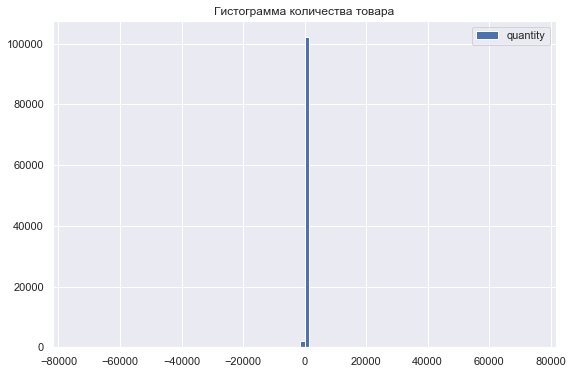

In [28]:
show_hist(df, 'quantity', bins=100, title='Гистограмма количества товара')

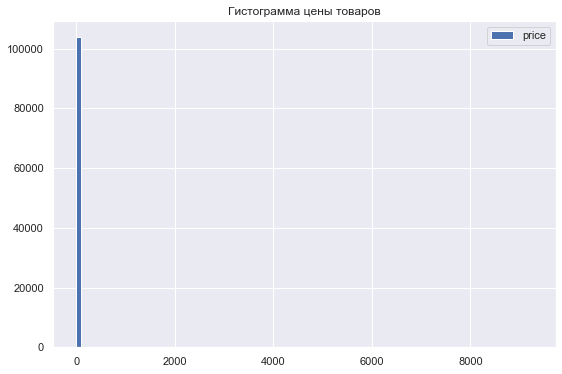

In [29]:
show_hist(df, 'price', bins=100, title='Гистограмма цены товаров')

In [30]:
def show_box(data, col, title=''):                   #функция построения диаграмм распределения
    plt.figure(figsize=(9, 6))
    sns.boxplot(x=col, data=data)
    plt.title(title)
    plt.show()

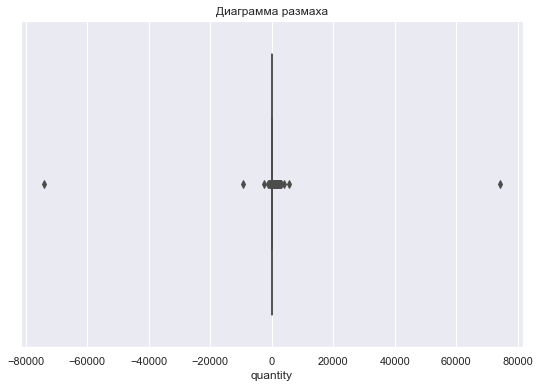

In [31]:
show_box(df, 'quantity', title='Диаграмма размаха')

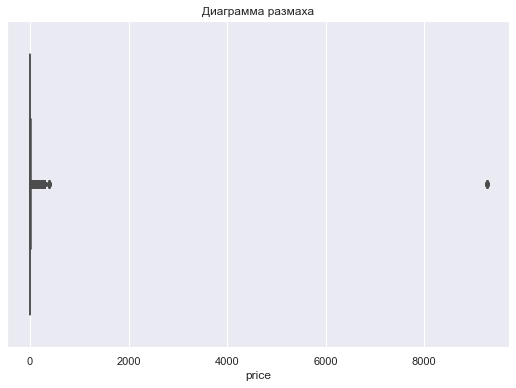

In [32]:
show_box(df, 'price', title='Диаграмма размаха')

По графика видно, что данные содержат выбросы, их следует обработать.

### Обработка недопустимых значений

Поскольку в данных имеются "артефактные" значения, от них следует избавится.

Начнем со столбца 'quantity':

Прежде всего нужно обратить внимание, что в нем имеются отрацательные значения, что совершенно нелогично. Думаю это ошибка техническа ошибка при записи данных, поэтому просто возмем все значения по модулю.

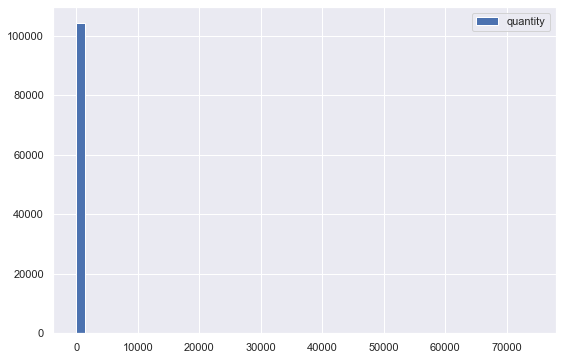

In [33]:
df['quantity'] = df['quantity'].abs()
show_hist(df, 'quantity')

Отрицательные значения устранены, теперь необходимо обработать большое количество нулевых значений. Их возникновение возможно объяснить либо возвратом тоовара, либо отменой покупки на определенном этапе в интернет-магазине.

Строки с нулевым количеством товаров нужно удалить, к сожалению в данном исследовании никак не получится использовать эти данные, и даже наоборот исказит результаты, наличие чека без прибыли уменьшит значение среднего чека. Но удалять следует не все строки, потому что хотя пользователь и не купил товар, но он проявил активность, а это уже можно использовать. Поэтому удалим строки с нулевым количеством товара и неизвестным ID покупателя:

In [34]:
df = df[~((df['quantity'] == 0) & (df['customer_id'] == 'Unknown'))]
df

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty,price
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.81
2,540418,21873,1,2017-01-07 11:04:00,Unknown,Shop 0,0,1.81
3,541516,21873,2,2017-01-18 17:34:00,Unknown,Shop 0,0,1.81
4,541566,21873,35,2017-01-19 11:50:00,23401,Shop 0,1,1.81
5,538843,21873,1,2016-12-14 13:18:00,21712,Shop 0,0,1.81
...,...,...,...,...,...,...,...,...
104358,538200,15058A,0,2016-12-10 11:11:00,23591,Shop 0,1,7.95
104359,538852,90058B,35,2016-12-14 13:33:00,23051,Shop 0,1,0.38
104360,539988,46138B,1,2016-12-23 16:06:00,23795,Shop 0,1,1.95
104362,542731,17028J,5,2017-01-31 15:27:00,19279,Shop 0,0,0.42


Теперь следует устранить выбросы в столбце:

count    71290.000000
mean         9.383237
std         14.621620
min          1.000000
25%          2.000000
50%          5.000000
75%         11.000000
max        121.000000
Name: quantity, dtype: float64


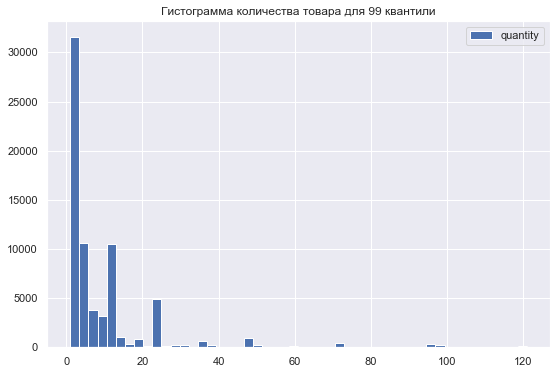

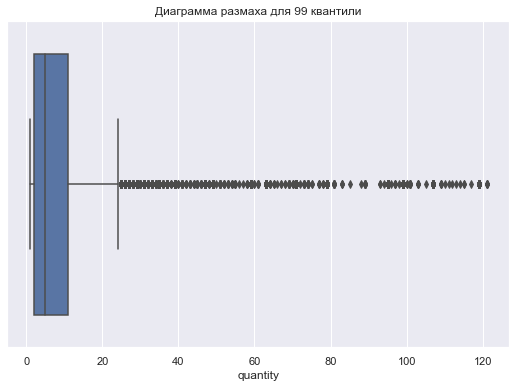

count    70830.000000
mean         8.756205
std         12.398051
min          1.000000
25%          2.000000
50%          5.000000
75%         11.000000
max         95.000000
Name: quantity, dtype: float64


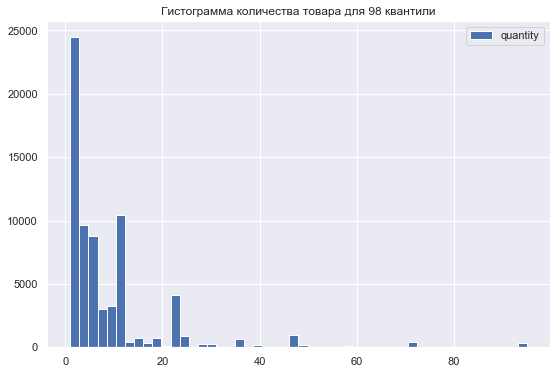

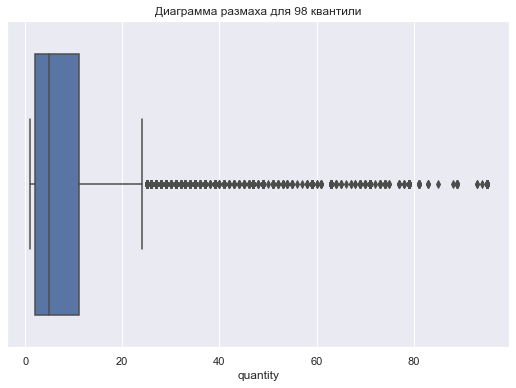

count    69921.000000
mean         7.830881
std          9.331898
min          1.000000
25%          2.000000
50%          5.000000
75%         11.000000
max         59.000000
Name: quantity, dtype: float64


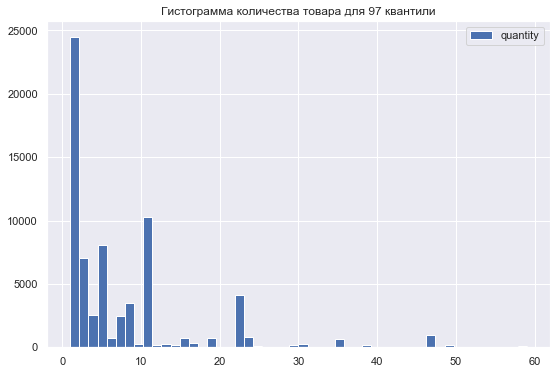

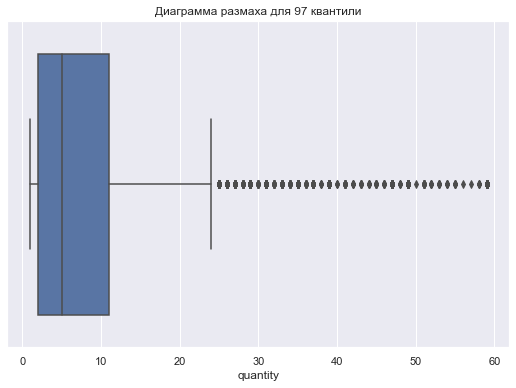

In [35]:
df_without_zero = df[df['quantity'] != 0]      #распределение данных берется без нулевых значений
for i in np.arange(.99, .97, -.01):
    test = df_without_zero[df_without_zero['quantity'] <= df_without_zero['quantity'].quantile(i)]
    print(test['quantity'].describe())
    show_hist(test, 'quantity', bins=50, title=f'Гистограмма количества товара для {int(i * 100)} квантили')
    show_box(test, 'quantity', title=f'Диаграмма размаха для {int(i * 100)} квантили')

In [36]:
df_without_zero['quantity'].quantile(.97)

59.0

In [37]:
df = df[df['quantity'] <= 59]
df

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty,price
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.81
2,540418,21873,1,2017-01-07 11:04:00,Unknown,Shop 0,0,1.81
3,541516,21873,2,2017-01-18 17:34:00,Unknown,Shop 0,0,1.81
4,541566,21873,35,2017-01-19 11:50:00,23401,Shop 0,1,1.81
5,538843,21873,1,2016-12-14 13:18:00,21712,Shop 0,0,1.81
...,...,...,...,...,...,...,...,...
104358,538200,15058A,0,2016-12-10 11:11:00,23591,Shop 0,1,7.95
104359,538852,90058B,35,2016-12-14 13:33:00,23051,Shop 0,1,0.38
104360,539988,46138B,1,2016-12-23 16:06:00,23795,Shop 0,1,1.95
104362,542731,17028J,5,2017-01-31 15:27:00,19279,Shop 0,0,0.42


Наиболее оптимальным будет отказаться от значений 'quantity' больше 59, так мы теряем 3% данных, но получаем более нормированные данные.

Теперь можно приступить к данным в столбце 'price':

count    69225.000000
mean         3.949040
std          3.360838
min          0.120000
25%          1.740000
50%          2.910000
75%          4.880000
max         18.120000
Name: price, dtype: float64


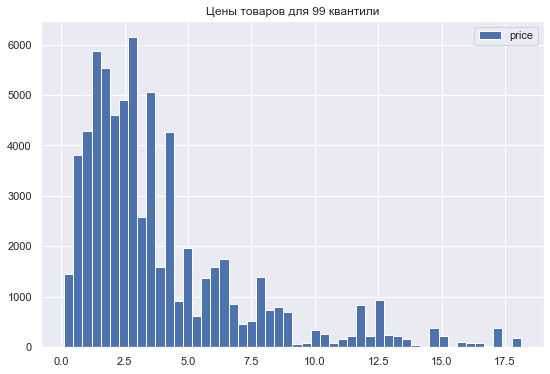

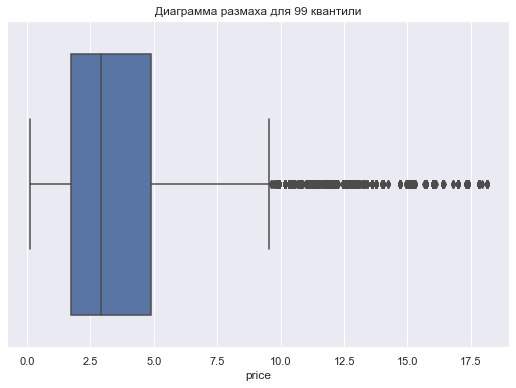

count    68481.000000
mean         3.804724
std          3.078383
min          0.120000
25%          1.720000
50%          2.860000
75%          4.850000
max         15.730000
Name: price, dtype: float64


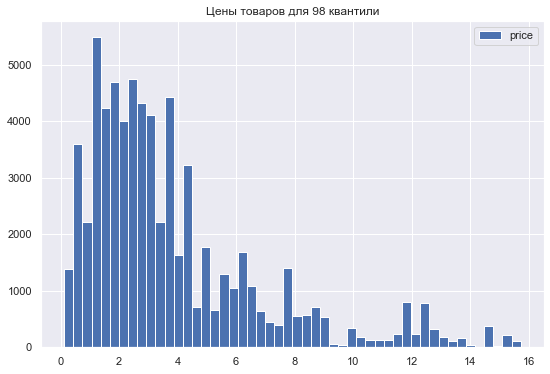

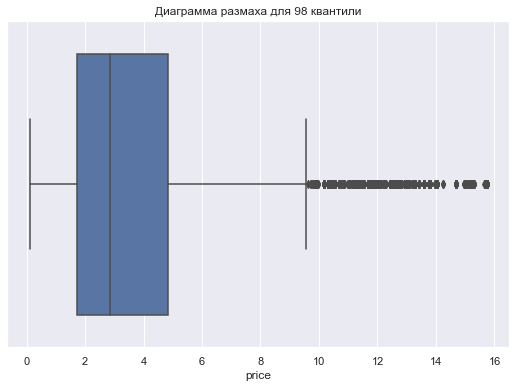

count    68130.000000
mean         3.745383
std          2.972849
min          0.120000
25%          1.700000
50%          2.860000
75%          4.820000
max         14.700000
Name: price, dtype: float64


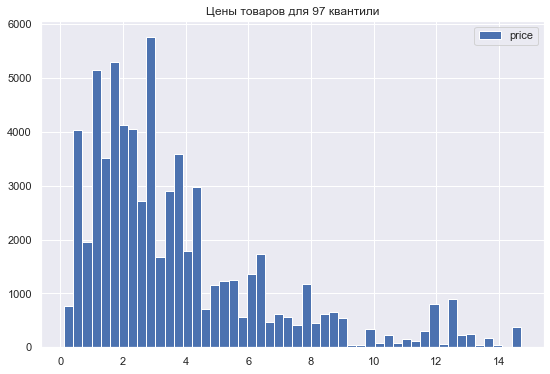

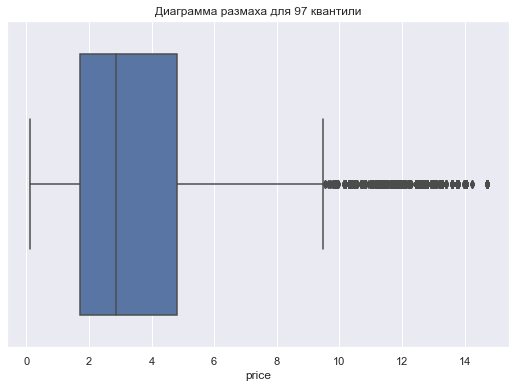

In [38]:
df_without_zero = df[df['quantity'] != 0]            #здесь так же не учитываются данные с нулевым 'quantity'
for i in np.arange(.99, .97, -.01):
    test = df_without_zero[df_without_zero['price'] <= df_without_zero['price'].quantile(i)]
    print(test['price'].describe())
    show_hist(test, 'price', bins=50, title=f'Цены товаров для {int(i * 100)} квантили')
    show_box(test, 'price', title=f'Диаграмма размаха для {int(i * 100)} квантили')

In [39]:
df_without_zero['price'].quantile(.99)

18.12

In [40]:
df = df[df['price'] <= 18.12]
df = df.reset_index(drop=True)

Откажемся от 1% данных и оставим товары с ценой 18.12 или меньше.

Исследовательский анализ данных произведен, и теперь можно приступать к выполнению поставленных задач.

## Оценка эффективности магазинов

Итак, оценим эффективность торговых точек. Для этого сравним изменение среднего чека покупателей за имеющийся период. Важно заметить, что в исследовании не будут учитываться данные с нулевым количеством товара, поскольку "покупка" которая не принесла прибыль повлияет на средний чек, а так же данные из магазинов покупки в которых совершались не на протяжении всего исследуемого периода, потому что данных по этим магазинам мало, и нельзя сказать однозначно эффективны они или нет.

In [41]:
df['month'] = df['purchase_date'].astype('datetime64[M]').dt.month
df['month'] = df['month'].replace({12:'december', 1:' january', 2:'february'})
df['year'] = df['purchase_date'].astype('datetime64[M]').dt.year
df['revenue'] = df['quantity'] * df['price']
df_without_zero = df[df['quantity'] != 0].reset_index(drop=True)
df_without_zero

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty,price,month,year,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.81,december,2016,19.91
1,540418,21873,1,2017-01-07 11:04:00,Unknown,Shop 0,0,1.81,january,2017,1.81
2,541516,21873,2,2017-01-18 17:34:00,Unknown,Shop 0,0,1.81,january,2017,3.62
3,541566,21873,35,2017-01-19 11:50:00,23401,Shop 0,1,1.81,january,2017,63.35
4,538843,21873,1,2016-12-14 13:18:00,21712,Shop 0,0,1.81,december,2016,1.81
...,...,...,...,...,...,...,...,...,...,...,...
69220,539009,79329,5,2016-12-15 13:24:00,18900,Shop 0,0,1.65,december,2016,8.25
69221,538852,90058B,35,2016-12-14 13:33:00,23051,Shop 0,1,0.38,december,2016,13.30
69222,539988,46138B,1,2016-12-23 16:06:00,23795,Shop 0,1,1.95,december,2016,1.95
69223,542731,17028J,5,2017-01-31 15:27:00,19279,Shop 0,0,0.42,january,2017,2.10


In [42]:
df_grouped = df_without_zero.groupby(['shop_id', 'year', 'month'])['purchase_id'].nunique().reset_index()
small = df_grouped.groupby('shop_id')['month'].count()
small = small[small < 3]                                      
small = small.index.tolist()
small                                    

['Shop 13',
 'Shop 15',
 'Shop 17',
 'Shop 20',
 'Shop 23',
 'Shop 24',
 'Shop 25',
 'Shop 26',
 'Shop 27',
 'Shop 28',
 'Shop 29',
 'Shop 30',
 'Shop 5']

In [43]:
data = df_without_zero[~df_without_zero['shop_id'].isin(small)]
data

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty,price,month,year,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.81,december,2016,19.91
1,540418,21873,1,2017-01-07 11:04:00,Unknown,Shop 0,0,1.81,january,2017,1.81
2,541516,21873,2,2017-01-18 17:34:00,Unknown,Shop 0,0,1.81,january,2017,3.62
3,541566,21873,35,2017-01-19 11:50:00,23401,Shop 0,1,1.81,january,2017,63.35
4,538843,21873,1,2016-12-14 13:18:00,21712,Shop 0,0,1.81,december,2016,1.81
...,...,...,...,...,...,...,...,...,...,...,...
69220,539009,79329,5,2016-12-15 13:24:00,18900,Shop 0,0,1.65,december,2016,8.25
69221,538852,90058B,35,2016-12-14 13:33:00,23051,Shop 0,1,0.38,december,2016,13.30
69222,539988,46138B,1,2016-12-23 16:06:00,23795,Shop 0,1,1.95,december,2016,1.95
69223,542731,17028J,5,2017-01-31 15:27:00,19279,Shop 0,0,0.42,january,2017,2.10


Теперь остались данные по магазинам в которых совершались покупки в каждом месяце установленного периода. Однако нельзя приступить к оценке эффективности, потому что еще имеются данные по магазинам в которых совершалось слишком мало покупок за весь период. И может так получиться, что за несколько покупок были приобретены ценные товары, и это сразу же повысит показатель среднего чека, хотя на самом деле магазин не так уж и успешен, если в нем совершается так мало покупок.

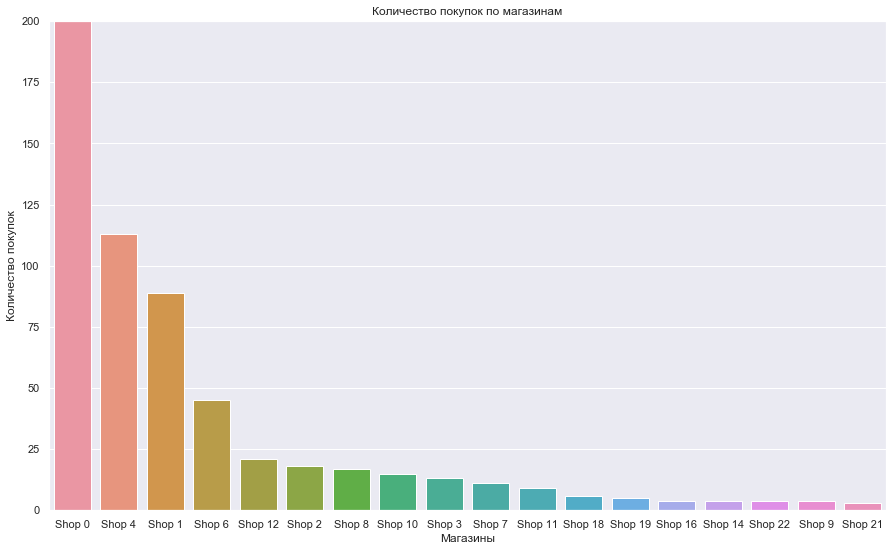

In [44]:
df_grouped = data.groupby(['shop_id', 'year', 'month'])['purchase_id'].nunique().reset_index()
count = df_grouped.groupby('shop_id')['purchase_id'].sum().reset_index().sort_values(by='purchase_id', ascending=False)
plt.figure(figsize=(15, 9))
sns.barplot(x = 'shop_id', y = 'purchase_id', data = count)
plt.ylim(0, 200)
plt.title('Количество покупок по магазинам')
plt.ylabel('Количество покупок')
plt.xlabel('Магазины')
plt.show()

In [45]:
count

,shop_id,purchase_id
0,Shop 0,3933
13,Shop 4,113
1,Shop 1,89
14,Shop 6,45
4,Shop 12,21
9,Shop 2,18
16,Shop 8,17
2,Shop 10,15
12,Shop 3,13
15,Shop 7,11


Оставим только те магазины в которых суммарно за весь период было совершено хотябы 15 покупок:

In [46]:
small = df_grouped.groupby('shop_id')['purchase_id'].sum()
small = small[small < 15]                                      
small = small.index.tolist()
small  

['Shop 11',
 'Shop 14',
 'Shop 16',
 'Shop 18',
 'Shop 19',
 'Shop 21',
 'Shop 22',
 'Shop 3',
 'Shop 7',
 'Shop 9']

In [47]:
data = data[~data['shop_id'].isin(small)]
data

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty,price,month,year,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.81,december,2016,19.91
1,540418,21873,1,2017-01-07 11:04:00,Unknown,Shop 0,0,1.81,january,2017,1.81
2,541516,21873,2,2017-01-18 17:34:00,Unknown,Shop 0,0,1.81,january,2017,3.62
3,541566,21873,35,2017-01-19 11:50:00,23401,Shop 0,1,1.81,january,2017,63.35
4,538843,21873,1,2016-12-14 13:18:00,21712,Shop 0,0,1.81,december,2016,1.81
...,...,...,...,...,...,...,...,...,...,...,...
69220,539009,79329,5,2016-12-15 13:24:00,18900,Shop 0,0,1.65,december,2016,8.25
69221,538852,90058B,35,2016-12-14 13:33:00,23051,Shop 0,1,0.38,december,2016,13.30
69222,539988,46138B,1,2016-12-23 16:06:00,23795,Shop 0,1,1.95,december,2016,1.95
69223,542731,17028J,5,2017-01-31 15:27:00,19279,Shop 0,0,0.42,january,2017,2.10


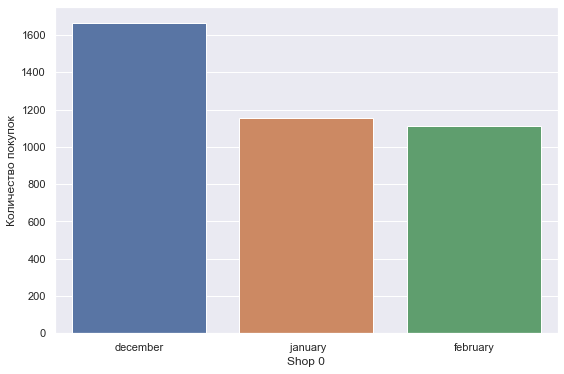

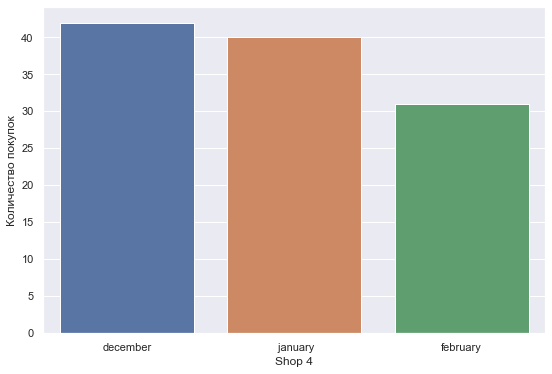

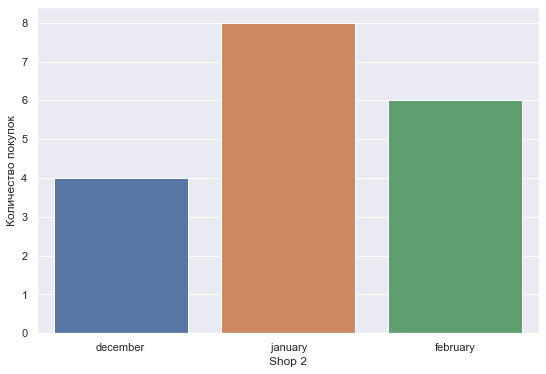

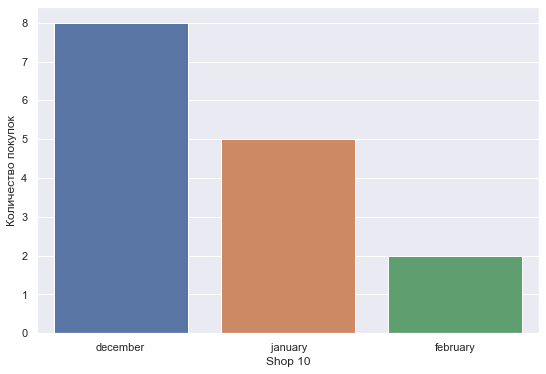

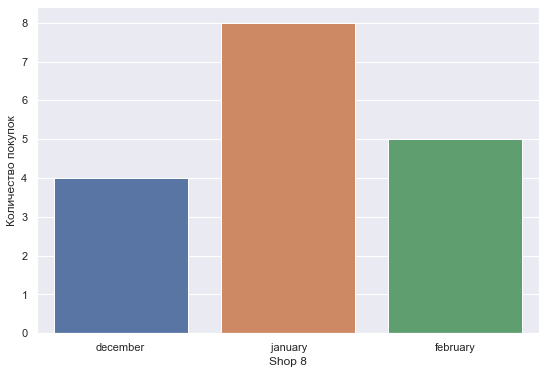

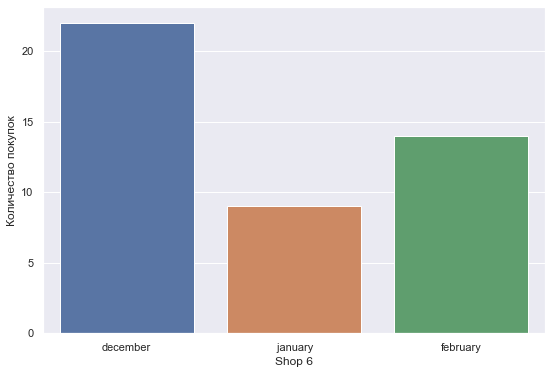

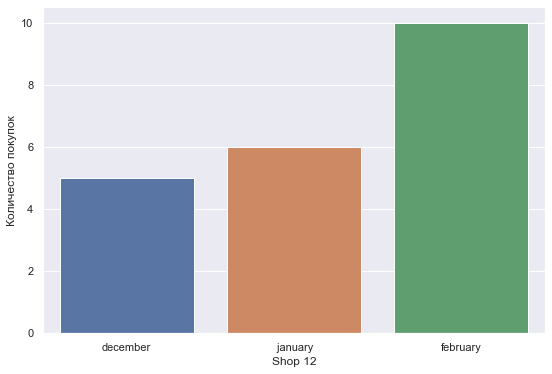

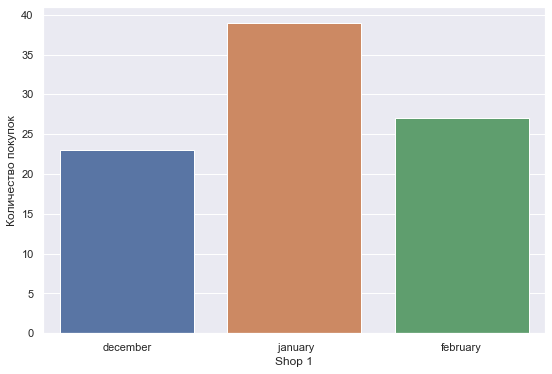

In [48]:
for i in data['shop_id'].unique().tolist():
    shop = data[data['shop_id'] == i]
    shop = shop.groupby(['year', 'month'])['purchase_id'].nunique().reset_index()
    plt.figure(figsize=(9, 6))
    sns.barplot(x = 'month', y = 'purchase_id', data=shop)
    plt.ylabel('Количество покупок')
    plt.xlabel(i)
    plt.show()

In [49]:
df_grouped = data.groupby(['shop_id', 'year', 'month']).agg({'purchase_id' : 'nunique', 'revenue' : 'sum'}).reset_index()
df_grouped['average_receipt'] = df_grouped['revenue'] / df_grouped['purchase_id']
df_grouped['average_receipt'] = df_grouped['average_receipt'].round(2)
df_grouped

,shop_id,year,month,purchase_id,revenue,average_receipt
0,Shop 0,2016,december,1667,587557.58,352.46
1,Shop 0,2017,january,1155,440875.43,381.71
2,Shop 0,2017,february,1111,371078.11,334.00
3,Shop 1,2016,december,23,11995.43,521.54
4,Shop 1,2017,january,39,20700.86,530.79
5,Shop 1,2017,february,27,11137.05,412.48
6,Shop 10,2016,december,8,3032.44,379.06
7,Shop 10,2017,january,5,5814.04,1162.81
8,Shop 10,2017,february,2,1380.76,690.38
9,Shop 12,2016,december,5,2418.36,483.67


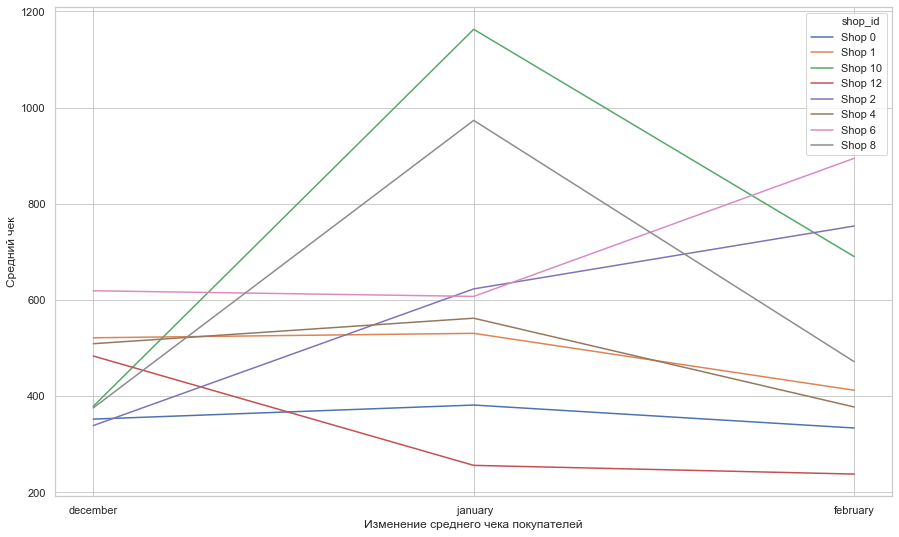

In [50]:
sns.set(style='whitegrid')
plt.figure(figsize=(15, 9))
sns.lineplot(data=df_grouped, x='month', y='average_receipt', hue='shop_id', sort=False)
plt.ylabel('Средний чек')
plt.xlabel('Изменение среднего чека покупателей')
plt.show()

In [51]:
pivot = df_grouped.pivot_table(columns='shop_id', index='month', values='average_receipt', aggfunc='first')
pivot

shop_id,Shop 0,Shop 1,Shop 10,Shop 12,Shop 2,Shop 4,Shop 6,Shop 8
month,,,,,,,,
january,381.71,530.79,1162.81,256.32,623.17,562.23,607.54,973.48
december,352.46,521.54,379.06,483.67,339.05,509.23,619.27,375.76
february,334.00,412.48,690.38,238.25,753.89,377.70,894.61,471.92


In [52]:
pivot = pd.DataFrame(pivot, index=['december', ' january', 'february'])
pivot

shop_id,Shop 0,Shop 1,Shop 10,Shop 12,Shop 2,Shop 4,Shop 6,Shop 8
december,352.46,521.54,379.06,483.67,339.05,509.23,619.27,375.76
january,381.71,530.79,1162.81,256.32,623.17,562.23,607.54,973.48
february,334.00,412.48,690.38,238.25,753.89,377.70,894.61,471.92


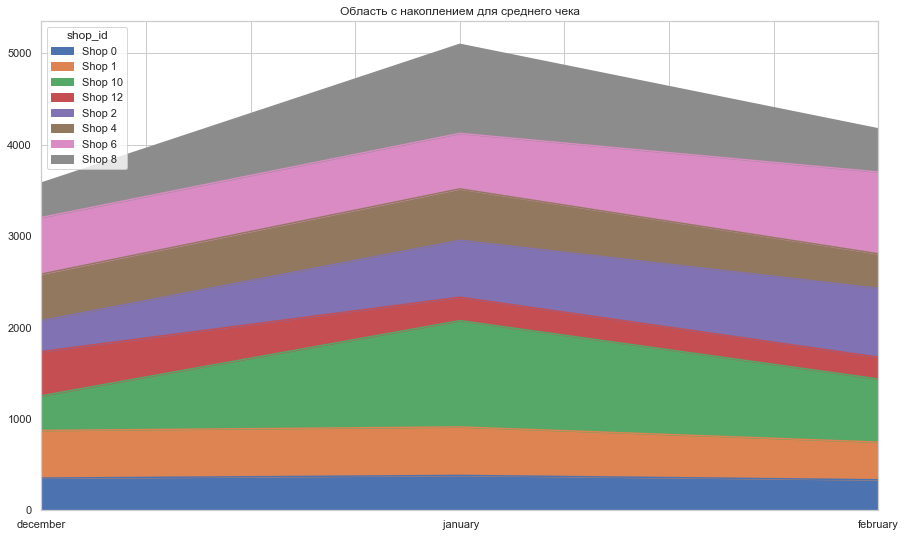

In [53]:
pivot.plot.area(figsize=(15, 9))
plt.title('Область с накоплением для среднего чека')
plt.show()

По итогам исследования можно выделить эффективные торговые точки, к ним относятся магазины с номерами: 2, 6, 8, 10. Из этого топа можно выделить 2 и 6, в них средний чек растет.

## Проверка эффективности программы лояльности

Политика сети магазинов предусматривает наличие программы лояльности для покупателей. Необходимо статистически сравнить эти две группы покупателей, и это покажет эффективна ли программа лояльности или нет. В качестве индикатора эффективности программы, также возьмем показатель среднего чека, и проверим равны ли средние чеки пользователей программы и средние чеки других покупателей.

### Формулировка гипотез

Составим четкие и однозначные нулевую и альтернативную ей гипотез.

Нулевая гипотеза(Н0) - средние чеки покупателей из программы лояльности и без программы **равны**

Альтернативная теория(Н1) - средние чеки различных покупателей **не равны**

### Проверка статистических гипотез

Проверим гипотезы с помощью средст библиотеки scipy.

Для начала проверим и подготовим выборки. Поскольку сравниваем средние чеки, данные с нулевым количеством товара не используем. Так же нужно проверить на протяжении всего ли исследуемого периода покупатели пользовались программой лояльности, и тем самым разделить их:

In [54]:
df_without_zero                 

,purchase_id,product_id,quantity,purchase_date,customer_id,shop_id,loyalty,price,month,year,revenue
0,538280,21873,11,2016-12-10 12:50:00,18427,Shop 0,0,1.81,december,2016,19.91
1,540418,21873,1,2017-01-07 11:04:00,Unknown,Shop 0,0,1.81,january,2017,1.81
2,541516,21873,2,2017-01-18 17:34:00,Unknown,Shop 0,0,1.81,january,2017,3.62
3,541566,21873,35,2017-01-19 11:50:00,23401,Shop 0,1,1.81,january,2017,63.35
4,538843,21873,1,2016-12-14 13:18:00,21712,Shop 0,0,1.81,december,2016,1.81
...,...,...,...,...,...,...,...,...,...,...,...
69220,539009,79329,5,2016-12-15 13:24:00,18900,Shop 0,0,1.65,december,2016,8.25
69221,538852,90058B,35,2016-12-14 13:33:00,23051,Shop 0,1,0.38,december,2016,13.30
69222,539988,46138B,1,2016-12-23 16:06:00,23795,Shop 0,1,1.95,december,2016,1.95
69223,542731,17028J,5,2017-01-31 15:27:00,19279,Shop 0,0,0.42,january,2017,2.10


In [55]:
ident = df_without_zero[df_without_zero['customer_id'] != 'Unknown']
ident_gr = ident.groupby('customer_id')['loyalty'].mean()
ident_gr[(ident_gr < 1) & (ident_gr > 0)]

Series([], Name: loyalty, dtype: int32)

Итак, на протяжении всего периоди покупатель либо пользовался программой лояльности либо нет.

Пользователей без идентификатора, так же используем в исследовании. Будем считать, что каждый неизвестный покупатель совершил лишь одну покупку. Вместо ID пользователя присвоим таким покупателям ID чека, а сумма всего чека и будет для них средним чеком.

In [56]:
inco = df_without_zero[df_without_zero['customer_id'] == 'Unknown']
inco = inco.groupby('purchase_id')['revenue'].sum().reset_index()
inco = inco.rename(columns = {'purchase_id':'customer_id', 'revenue':'average_receipt'})
inco['loyalty'] = 0
inco

,customer_id,average_receipt,loyalty
0,536414,426.25,0
1,536544,2334.95,0
2,536553,2.50,0
3,536589,87.45,0
4,536592,3049.45,0
...,...,...,...
462,C541492,77.02,0
463,C542540,47.70,0
464,C542860,17.20,0
465,C543185,68.55,0


In [57]:
ident_grouped = ident.groupby('customer_id').agg({'purchase_id':'nunique', 'revenue':'sum', 'loyalty':'first'}).reset_index()
ident_grouped['average_receipt'] = ident_grouped['revenue'] / ident_grouped['purchase_id']
ident_grouped['average_receipt'] = ident_grouped['average_receipt'].round(2)
ident_grouped = ident_grouped[['customer_id', 'average_receipt', 'loyalty']]
ident_grouped

,customer_id,average_receipt,loyalty
0,18026.0,893.31,0
1,18027.0,206.12,0
2,18029.0,397.06,0
3,18031.0,385.44,0
4,18035.0,3355.65,0
...,...,...,...
1680,23938.0,588.57,1
1681,23939.0,350.02,1
1682,23948.0,130.99,1
1683,23956.0,34.74,1


In [58]:
df_customer = pd.concat([ident_grouped, inco]).reset_index(drop=True)
df_customer

,customer_id,average_receipt,loyalty
0,18026,893.31,0
1,18027,206.12,0
2,18029,397.06,0
3,18031,385.44,0
4,18035,3355.65,0
...,...,...,...
2147,C541492,77.02,0
2148,C542540,47.70,0
2149,C542860,17.20,0
2150,C543185,68.55,0


Теперь все готово, осталось подготовить выборки для теста:

In [59]:
loyalty = df_customer[df_customer['loyalty'] == 1]
loyalty

,customer_id,average_receipt,loyalty
1121,22005,110.06,1
1122,22006,811.24,1
1123,22011,107.40,1
1124,22018,8.49,1
1125,22029,274.76,1
...,...,...,...
1680,23938,588.57,1
1681,23939,350.02,1
1682,23948,130.99,1
1683,23956,34.74,1


In [60]:
not_loyalty = df_customer[df_customer['loyalty'] == 0]
not_loyalty

,customer_id,average_receipt,loyalty
0,18026,893.31,0
1,18027,206.12,0
2,18029,397.06,0
3,18031,385.44,0
4,18035,3355.65,0
...,...,...,...
2147,C541492,77.02,0
2148,C542540,47.70,0
2149,C542860,17.20,0
2150,C543185,68.55,0


Выборки сильно различаются по размеру, это следует учесть при проведении теста.

Приступим к проверке статистических гипотез:

In [61]:
loyalty = loyalty['average_receipt']
not_loyalty = not_loyalty['average_receipt']

alpha = 0.05                                    

results = st.ttest_ind(loyalty, not_loyalty, equal_var = False)  #из-за различия размеров выборок equal_var = False

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не удалось отвергнуть нулевую гипотезу.')

p-значение: 5.25236187685452e-05
Отвергаем нулевую гипотезу.


In [62]:
loyalty.mean()

329.3329787234042

In [63]:
not_loyalty.mean()

411.2206612090681

Тест однозначно утверждает, что средние чеки покупателей отличаются. Вот только их среднее значение для покупателей из программы меньше чем для покупателей без неё, а это означает что программа не так уж и эффективна.

## Вывод и рекомендации

По результатам исследования, можно определить эффективные торговые точки, ими являются магазины под номерами: 2, 6, 8 и 10, развитие остальных точек следует организовать по такому же сценарию и прообразу, как для этих магазинов.

Так же, исследование показало, что программа лояльности не является такой уж и эффективной, ожидалось что ее пользователи являются более прибыльными, но это не так. Поэтому следует внести изменения в политику данной программы.